In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

In [2]:
# Import csv data
df = pd.read_csv('..\\Data\\all_pitches.csv')

In [3]:
df.head()

,game_id,batSide_code,batSide_des,batter,batter_id,call_des,inning_top_bot,pitchHand_code,pitchHand_des,pitch_type,...,strike_left,strike_down_right,strike_down,strike_down_left,call_B,call_C,call_F,call_H,call_S,is_out
0,413661,L,Left,Matt Carpenter,572761,Called Strike,top,L,Left,FF,...,0,0,0,0,0,1,0,0,0,0
1,413661,L,Left,Matt Carpenter,572761,Swinging Strike,top,L,Left,FF,...,0,0,0,0,0,0,0,0,1,0
2,413661,L,Left,Matt Carpenter,572761,Foul,top,L,Left,FF,...,0,0,0,0,0,0,1,0,0,0
3,413661,L,Left,Matt Carpenter,572761,Ball,top,L,Left,FF,...,0,0,0,0,1,0,0,0,0,0
4,413661,L,Left,Matt Carpenter,572761,Ball,top,L,Left,CU,...,0,0,0,0,1,0,0,0,0,0


# Exploratory Data Analysis

For this project, we want to find out if we can optimize a pitcher's pitch count to get more outs in less pitches. More specifically, which pitches tend to be most effective against which batters and in what location? It's a common expression to pitch "hard stuff in, soft stuff away"; basically to pitch fastballs closer to a batter in the strikezone and off-speed pitches futher away from the batter. This analysis will look into that idiom and determine which pitches, and where, tend to lead to outs.

In [4]:
# Separate target variables
target_cols = ['call_B', 'call_C', 'call_F', 'call_H', 'call_S', 'is_out']

In [5]:
targets = df[target_cols]

In [6]:
targets.head()

,call_B,call_C,call_F,call_H,call_S,is_out
0,0,1,0,0,0,0
1,0,0,0,0,1,0
2,0,0,1,0,0,0
3,1,0,0,0,0,0
4,1,0,0,0,0,0


First we need to look at how often an outcome occurred when a pitch was thrown throughout the 2015-2017 MLB seasons.

In [7]:
# Print percentage of pitches produced which outcomes
print("%i pitches from the 2015-2017 seasons are being analyzed." % len(targets))
targets.mean()

2129403 pitches from the 2015-2017 seasons are being analyzed.


call_B    0.360146
call_C    0.168416
call_F    0.173895
call_H    0.064159
call_S    0.114559
is_out    0.173634
dtype: float64

Note that the percentage of outcomes are near each other with ``call_B``, balls, and ``call_H``, hits, being the biggest disparity. It's also worth mentioning that the percentages add up to more than 1 and that's due to the ``is_out`` column. There are a number of ways a batter could be out, one of which would be to strikeout which would result in ``call_C``, or ``call_S``, being ``1``as well as ``is_out``. This leads to double counting which isn't a bad thing because I want the model to learn that getting 3 strikes is an out.

### Pitch Type & Location

When looking at the data, it's obvious that the different pitch types and locations are broken down into dummy variables. Although this will be useful when modeling the data, it proves a problem when doing exploratory data analysis so the first thing to do is to switch them back into categorical columns.

In [8]:
# Separate pitch types and pitch locations
pitch_types_dummies = df.filter(regex="pitch_type_*")

In [9]:
pitch_types_dummies.head()

,pitch_type,pitch_type_Changeup,pitch_type_Curveball,pitch_type_Cutter,pitch_type_Eephus,pitch_type_Fastball,pitch_type_Forkball,pitch_type_Four-Seam Fastball,pitch_type_Int. Ball,pitch_type_Knuckle Curve,pitch_type_Knuckleball,pitch_type_Pitchout,pitch_type_Screwball,pitch_type_Sinker,pitch_type_Slider,pitch_type_Splitter,pitch_type_Two-Seam Fastball,pitch_type_Unknown
0,FF,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
1,FF,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
2,FF,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,FF,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
4,CU,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
# Use stack to collapse the columns into 1
pitch_types = pitch_types_dummies[pitch_types_dummies==1].stack().reset_index().drop(['level_0', 0], 1)

In [11]:
pitch_types.columns = ['pitch_type']
pitch_types.head()

,pitch_type
0,pitch_type_Four-Seam Fastball
1,pitch_type_Four-Seam Fastball
2,pitch_type_Four-Seam Fastball
3,pitch_type_Four-Seam Fastball
4,pitch_type_Curveball


In [12]:
# Set strikezone divisions
# Consider importing these from Data_Wrangling in the future
sz_top = 3.406
sz_bot = 1.321
sz_right = -1.181
sz_left = 1.133
sz_top_third = 2.711
sz_bot_third = 2.016
sz_right_third = -0.410
sz_left_third = 0.362

In [13]:
df.loc[df['pitch_locx'] < sz_right, 'loc_x'] = 'ballX_right'
df.loc[(df['pitch_locx'] > sz_right) & (df['pitch_locx'] < sz_right_third), 'loc_x'] = 'strikeX_right'
df.loc[(df['pitch_locx'] > sz_right_third) & (df['pitch_locx'] < sz_left_third), 'loc_x'] = 'strikeX_mid'
df.loc[(df['pitch_locx'] > sz_left_third) & (df['pitch_locx'] < sz_left), 'loc_x'] = 'strikeX_left'
df.loc[(df['pitch_locx'] > sz_left), 'loc_x']= 'ballX_left'

In [14]:
df.loc[df['pitch_locy'] < sz_bot, 'loc_y'] = 'ballY_bot'
df.loc[(df['pitch_locy'] > sz_bot) & (df['pitch_locy'] < sz_bot_third), 'loc_y'] = 'strikeY_bot'
df.loc[(df['pitch_locy'] > sz_bot_third) & (df['pitch_locy'] < sz_top_third), 'loc_y'] = 'strikeY_mid'
df.loc[(df['pitch_locy'] > sz_top_third) & (df['pitch_locy'] < sz_top), 'loc_y'] = 'strikeY_top'
df.loc[(df['pitch_locy'] > sz_top), 'loc_y']= 'ballY_top'

Now that the dummy variables have been condensed and pitch locations categorized, a new data frame can be created to do some exploratory data analysis.

In [15]:
# Filter out relevant columns to keep from df
eda_df = df[['batSide_des', 'pitchHand_des', 'count_balls', 'count_strikes', 'inning_num', 'pitch_speed', 'loc_x', 'loc_y']]

In [16]:
# Join targets, pitch_types, pitch_locs
eda_df = eda_df.join([pitch_types, targets])
eda_df.head()

,batSide_des,pitchHand_des,count_balls,count_strikes,inning_num,pitch_speed,loc_x,loc_y,pitch_type,call_B,call_C,call_F,call_H,call_S,is_out
0,Left,Left,0,0,1,92.9,strikeX_left,strikeY_top,pitch_type_Four-Seam Fastball,0,1,0,0,0,0
1,Left,Left,0,1,1,92.8,strikeX_mid,strikeY_mid,pitch_type_Four-Seam Fastball,0,0,0,0,1,0
2,Left,Left,0,2,1,94.1,strikeX_right,strikeY_top,pitch_type_Four-Seam Fastball,0,0,1,0,0,0
3,Left,Left,0,2,1,91.0,strikeX_right,ballY_bot,pitch_type_Four-Seam Fastball,1,0,0,0,0,0
4,Left,Left,1,2,1,75.4,ballX_right,strikeY_mid,pitch_type_Curveball,1,0,0,0,0,0


## Visualizations

This premise behind this project is to determine if there's a pattern that batters tend to follow. Do high curveballs lead to more hits? Does the idiom "hard stuff in, soft stuff away" hold true? These are a couple of patterns to look into in this analysis. The function below takes in the data being used, which side the batter is hitting from, pitch type thrown and outcome of the pitch as parameters and returns the mean and count matrix of how often the pitches thrown at a specific location produced the outcome specified. It also displays heat maps as an indicator.

In [17]:
# Group outs by batSide, pitchHand, pitch_type, pitch_loc
def heat_map(data, bat_side, pitch_types, call):
    '''Plot and return number of a certain pitch is thrown to a certain batter by a certain pitcher given the outcome call.
    Should plot two heat maps. The first is percent of outs in regards to the parameters. The second is total number of
    pitches produced the outcome call.'''
    hm_df = pd.DataFrame()
    
    for pitch in pitch_types:
        pitch_cat = 'pitch_type_' + pitch
        hm_df = hm_df.append(data[(data['batSide_des'] == bat_side) & (data['pitch_type'] == pitch_cat)])
    
    # Pivot hm_df to take average of outcome call by location
    hm_df_call = hm_df.loc[:,['loc_x', 'loc_y', call]]
    hm_pivot_mean = hm_df_call.pivot_table(index='loc_y', columns='loc_x', values=call, aggfunc='mean')
    hm_pivot_mean = hm_pivot_mean.reindex(['ballX_right', 'strikeX_right', 'strikeX_mid', 'strikeX_left', 'ballX_left'], axis=1)
    hm_pivot_mean = hm_pivot_mean.reindex(['ballY_top', 'strikeY_top', 'strikeY_mid', 'strikeY_bot', 'ballY_bot'], axis=0)
    
    # Pivot hm_df to take count of outcome call by location
    hm_df_count = hm_df[hm_df[call] == 1]
    hm_df_count = hm_df_count[['loc_x', 'loc_y', call]]
    hm_pivot_count = hm_df_count.pivot_table(index='loc_y', columns='loc_x', values=call, aggfunc='count')
    hm_pivot_count = hm_pivot_count.reindex(['ballX_right', 'strikeX_right', 'strikeX_mid', 'strikeX_left', 'ballX_left'], axis=1)
    hm_pivot_count = hm_pivot_count.reindex(['ballY_top', 'strikeY_top', 'strikeY_mid', 'strikeY_bot', 'ballY_bot'], axis=0)
    
    # Plot heatmaps for both pivoted dataframes
    _ = plt.figure(figsize=(10, 20))
    _ = plt.subplot(2, 1, 1)
    hm_pivot_mean_max = hm_pivot_mean.values.max()
    hm_pivot_mean_min = hm_pivot_mean.values.min()
    heatmap_mean_center = (hm_pivot_mean_max - hm_pivot_mean_min)/2
    _ = sns.heatmap(hm_pivot_mean, cmap = 'coolwarm', center = heatmap_mean_center)
    _ = plt.title('Percent %s by %s-Handed Batter from %s' %(call, bat_side, pitch_types))
    
    _ = plt.subplot(2, 1, 2)
    hm_pivot_count_max = hm_pivot_count.values.max()
    hm_pivot_count_min = hm_pivot_count.values.min()
    heatmap_count_center = (hm_pivot_count_max - hm_pivot_count_min)/2
    _ = sns.heatmap(hm_pivot_count, cmap = 'coolwarm', center = heatmap_count_center)
    _ = plt.title('Number of %s by %s-Handed Batter from %s' %(call, bat_side, pitch_types))
    _ = plt.tight_layout()
    _ = plt.show()
    
    return hm_pivot_mean, hm_pivot_count

Something to note is the function takes doesn't account for which hand the pitcher pitches from. In theory, that affects how batters percieve the ball and opposite side matchups benefits the batter. Again, it's something that could be added in future exploration.

Now when it comes to comparing outcomes of a certain pitch(``heat_map`` outputs) to the overall mean of pitches thrown at the same location producing the same outcome, a simple t-test will be used to determine its significance. The function below will take ``bat_side``, ``pitch_type``, ``call``, ``locx_zone``, and ``locy_zone`` as parameters and output the p-value and test statistic and with an alpha of 5%, a conclusion could be made or hypothesized based on the null hypothesis that the means are the same.

In [18]:
# Create a function to do t-testing
def t_testing(eda_data, bat_side, pitch_types, call, locx_zone, locy_zone, alpha = 0.05):
    '''This function will test if a pitch_type in location locx_zone and locy_zone to a bater of bat_side produces a significant
    difference in means to a typical pitch at the same location to the same bat_side'''
    pitch_type_list = []
    all_pitches_by_call = pd.Series()
    testing_series = pd.Series()
    
    # Need to append label to pitches in pitch_type
    for pitch in pitch_types:
        pitch_cat = 'pitch_type_' + pitch
        pitch_type_list.append(pitch_cat)
        
        # Create a series with pitches in pitch_type
        testing_series = testing_series.append(eda_data[(eda_data['batSide_des'] == bat_side) & (eda_data['loc_x'].isin(locx_zone)) & (eda_data['loc_y'].isin(locy_zone)) & (eda_data['pitch_type'] == pitch_cat)][call])
    
    # Create a series excluding pitches in pitch_type
    all_pitches_by_call = all_pitches_by_call.append(eda_data[(eda_data['batSide_des'] == bat_side) & (eda_data['loc_x'].isin(locx_zone)) & (eda_data['loc_y'].isin(locy_zone)) & ~(eda_data['pitch_type'].isin(pitch_type_list))][call])
    print("Total pitches: %i. Mean %s: %f." %(len(all_pitches_by_call), call, all_pitches_by_call.mean()))
    print("Total %s: %i. Mean %s: %f." %(pitch_types, len(testing_series), call, testing_series.mean()))
    
    # Perform a t-test on the two series
    t_stat, p_val = stats.ttest_ind(all_pitches_by_call, testing_series, equal_var = False)
    
    # Print a statement depending on resulting p-value
    if p_val > alpha:
        print("There's no statistical significance for getting %s against %s-handed batters by throwing a %s at %s and %s" %(call, bat_side, pitch_types, locx_zone, locy_zone))
        print("Test statistic: %f. P-value: %f" %(t_stat, p_val))
    else:
        print("There's a statistical significance for getting %s against %s-handed batters by throwing a %s at %s and %s opposed to other pitches" %(call, bat_side, pitch_types, locx_zone, locy_zone))
        print("Test statistic: %f. P-value: %f" %(t_stat, p_val))

### "Hard Stuff In..."

The phrase "Hard stuff in, soft stuff away" is used to describe how you should pitch to most batters. It's said that it disrupts the batters rhythm and creates deception of the pitches thrown. "Hard stuff" typically pertains to fast, harder thrown pitches like cutters, four-seam fastballs, two-seam fastballs, and in rare cases, sinkers.

In [19]:
# Create a list of hard pitches
hard_stuff = ['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball']

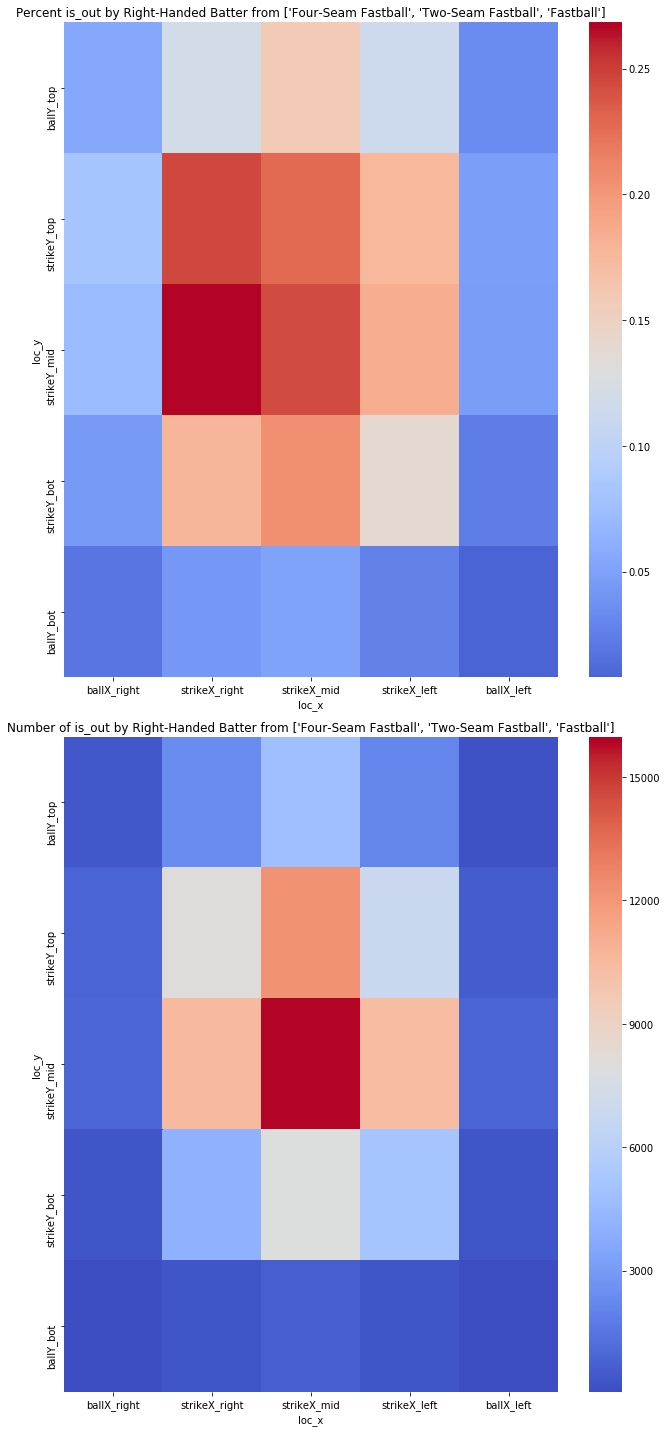

In [20]:
# Plot a heatmap for hard stuff to right-handed batters
hs_right_outs_mean, hs_right_outs_count = heat_map(eda_df,
                                                   bat_side = 'Right',
                                                   pitch_types = hard_stuff,
                                                   call='is_out')

Displayed in the two heatmaps above are all four-seam fastballs, two-seam fastballs, and pitches labeled as fastballs by location. The top represents the percentage of fastballs pitched in a specific location produced an out whereas the second is purely a count of how many outs were produced by a fastball in that location. There may be a concern as to why these plots don't look similar but that's because although pitches thrown in a specific location produced more outs, the number of pitches, or count, it took to get those many outs is much greater. There's a similar, but mirrored, pattern shown below when pertaining to left-handed batters.

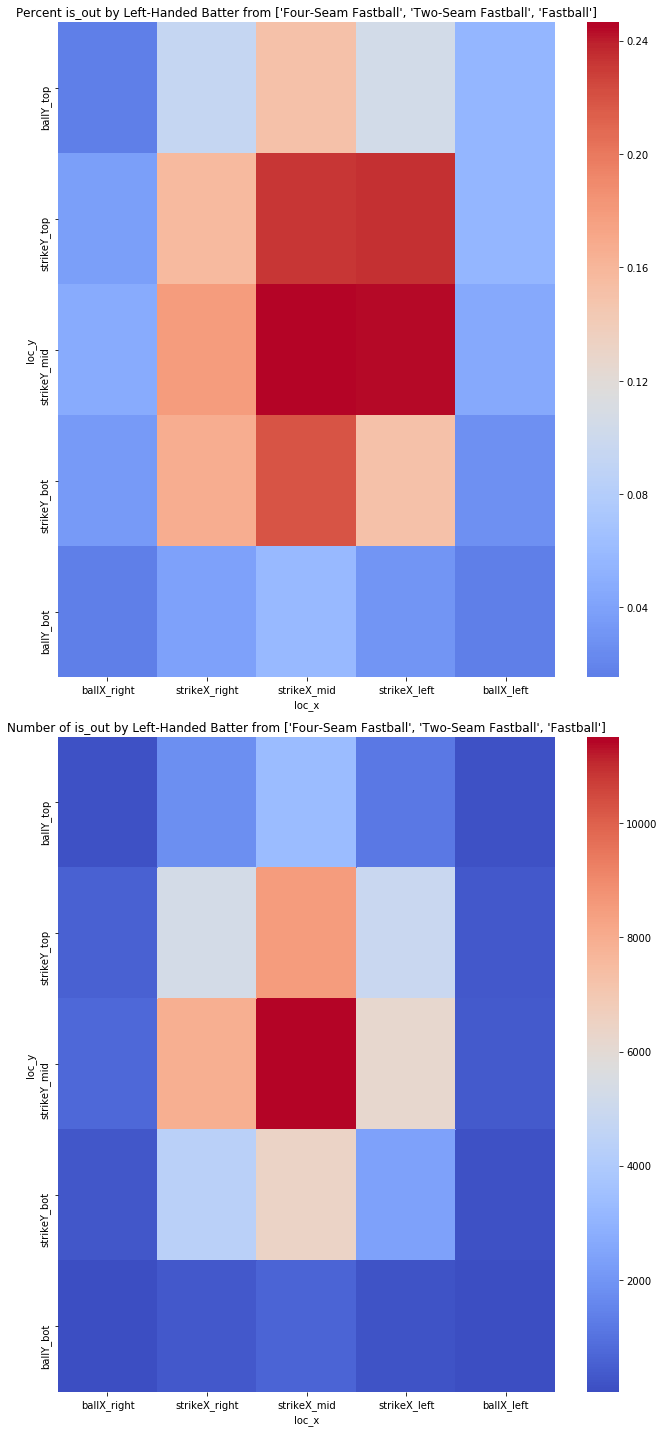

In [21]:
hs_left_outs_mean, hs_left_outs_count = heat_map(eda_df,
                                                 bat_side = 'Left',
                                                 pitch_types = hard_stuff,
                                                 call = 'is_out')

In [22]:
# Test the significance of hard stuff in to right-handed batters
t_testing(eda_df,
          bat_side = 'Right',
          pitch_types = hard_stuff, 
          call = 'is_out', 
          locx_zone = ['strikeX_right'],
          locy_zone = ['strikeY_mid', 'stikeY_top', 'strikeY_bot'])

Total pitches: 57316. Mean is_out: 0.209209.
Total ['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball']: 61592. Mean is_out: 0.235485.
There's a statistical significance for getting is_out against Right-handed batters by throwing a ['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball'] at ['strikeX_right'] and ['strikeY_mid', 'stikeY_top', 'strikeY_bot'] opposed to other pitches
Test statistic: -10.901779. P-value: 0.000000


In [23]:
# Test the significance of hard stuff in to left-handed batters
t_testing(eda_df,
          bat_side='Left',
          pitch_types=['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball'],
          call = 'is_out',
          locx_zone=['strikeX_left'], 
          locy_zone=['strikeY_mid', 'stikeY_top', 'strikeY_bot'])

Total pitches: 43117. Mean is_out: 0.196883.
Total ['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball']: 41219. Mean is_out: 0.208569.
There's a statistical significance for getting is_out against Left-handed batters by throwing a ['Four-Seam Fastball', 'Two-Seam Fastball', 'Fastball'] at ['strikeX_left'] and ['strikeY_mid', 'stikeY_top', 'strikeY_bot'] opposed to other pitches
Test statistic: -4.218988. P-value: 0.000025


Using the ``t_testing`` function created above, we see that both t-tests proved that the average rate at which hard stuff pitched inside to a batter is greater than that of other pitches thrown in the same locations. The means might seem low or close together, but in a game where the difference between average and great hitting is 0.05, the difference in means for right-handed batters seem pratically significant and since the mean rate for hard stuff inside is greater than other pitches, it does seem like there's some truth to the statement. The discrepancy seems to be lessened for left-handed batters however and even though there is a difference, practically it may not make a difference.

###  "...Soft Stuff Away"

To create that deception and timing of the hitter, soft stuff pertains to slower pitches that have more movement such as curveballs, changeups, and splitters. Below are the heatmaps for outs by both right-handed and left-handed batters by location and the first thing you notice is that there's a higher density/percentage down and away from their respective batters.

In [24]:
soft_stuff = ['Curveball', 'Changeup', 'Splitter']

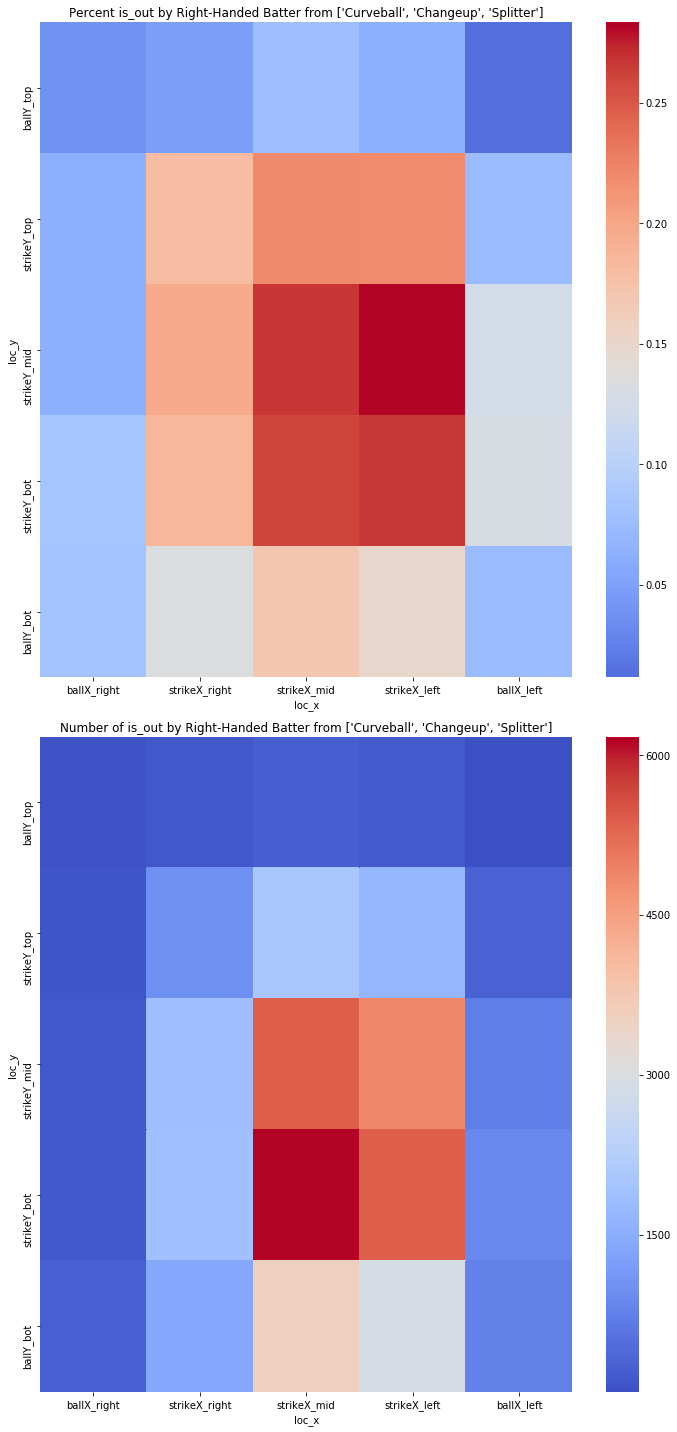

In [25]:
ss_right_outs_mean, ss_right_outs_count = heat_map(eda_df,
                                                   'Right',
                                                   soft_stuff,
                                                   'is_out')

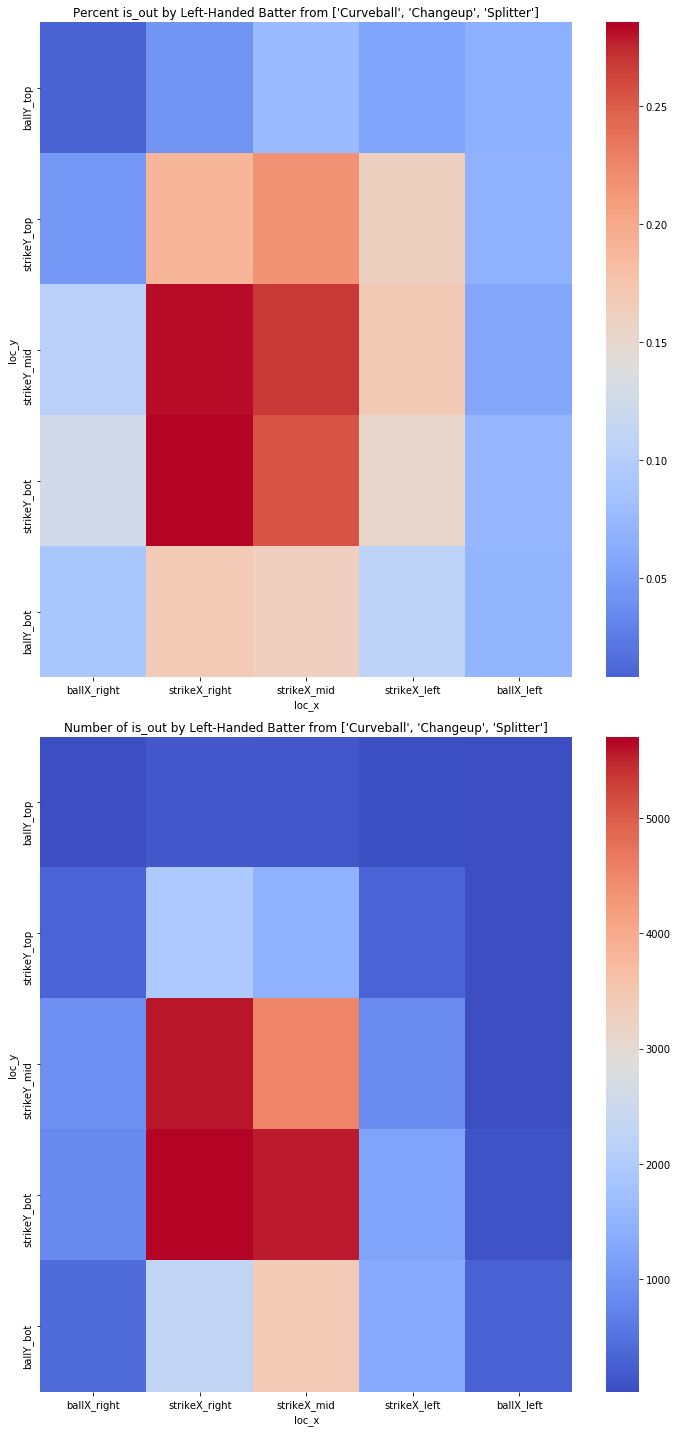

In [26]:
ss_left_outs_mean, ss_left_outs_count = heat_map(eda_df,
                                                 bat_side = 'Left',
                                                 pitch_types = soft_stuff,
                                                 call = 'is_out')

In [27]:
t_testing(eda_df,
         bat_side = 'Right',
         pitch_types = soft_stuff,
         locx_zone = ['strikeX_left'],
         locy_zone = ['strikeY_mid', 'strikeY_bot'],
         call = 'is_out')

Total pitches: 175662. Mean is_out: 0.197766.
Total ['Curveball', 'Changeup', 'Splitter']: 37387. Mean is_out: 0.273972.
There's a statistical significance for getting is_out against Right-handed batters by throwing a ['Curveball', 'Changeup', 'Splitter'] at ['strikeX_left'] and ['strikeY_mid', 'strikeY_bot'] opposed to other pitches
Test statistic: -30.546849. P-value: 0.000000


In [28]:
t_testing(eda_df,
         bat_side = 'Left',
         pitch_types = soft_stuff,
         locx_zone = ['strikeX_right'],
         locy_zone = ['strikeY_mid', 'strikeY_bot'],
         call = 'is_out')

Total pitches: 111058. Mean is_out: 0.193782.
Total ['Curveball', 'Changeup', 'Splitter']: 39774. Mean is_out: 0.283778.
There's a statistical significance for getting is_out against Left-handed batters by throwing a ['Curveball', 'Changeup', 'Splitter'] at ['strikeX_right'] and ['strikeY_mid', 'strikeY_bot'] opposed to other pitches
Test statistic: -35.253647. P-value: 0.000000


Looking at the t-test, we see that there is a significant difference in means between 'soft stuff' pitches and other pitches thrown away from the batter. Unlike hard stuff thrown in, the difference in means is much greater for getting outs with soft stuff away so it does seem like batters are less likely to succeed against soft pitches thrown away from them. This analysis doesn't however take into account the count/situation, pitch sequence, and matchups so throwing soft stuff all the time isn't guaranteed to work all the time but there does seem to be a pattern on how to get batters out which is the hopes of this project.

### "Mistakes Up"

Another common phrase that's said often in baseball is that breaking balls(pitches with lateral movement or break) left up are "mistakes" where "up" in this situation refers to the upper two-thirds of the strikezone. Mistake pitches are often called that because these pitches are slower and easier to hit and the curve/break of the ball allows it easier to get hit up in the air and sometimes even produce a home run. Below are the heatmaps for curveballs, sliders, changeups, etc. that registered as hits.

In [74]:
mistake_pitches = ['Changeup', 'Curveball', 'Slider', 'Splitter', 'Sinker']

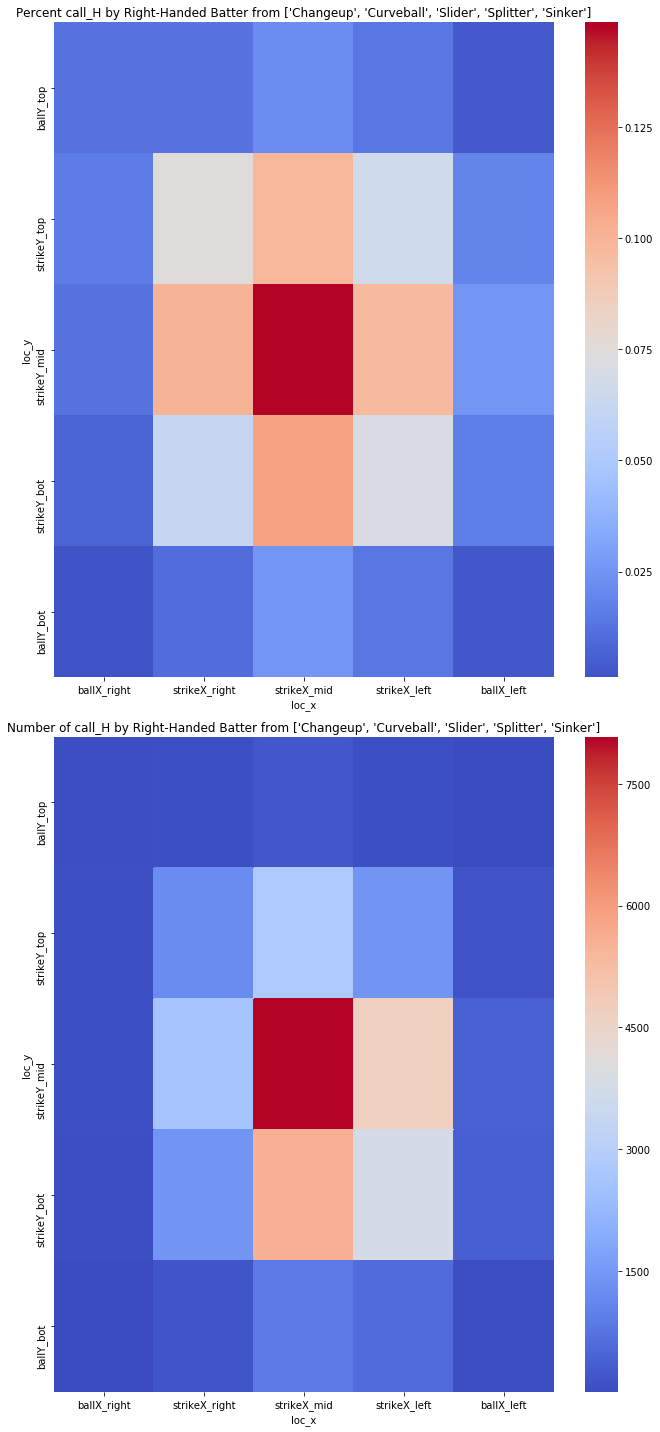

In [75]:
mistakes_right_hit_mean, mistakes_right_hit_count = heat_map(eda_df,
                                                             bat_side = 'Right',
                                                             pitch_types = mistake_pitches,
                                                             call = 'call_H')

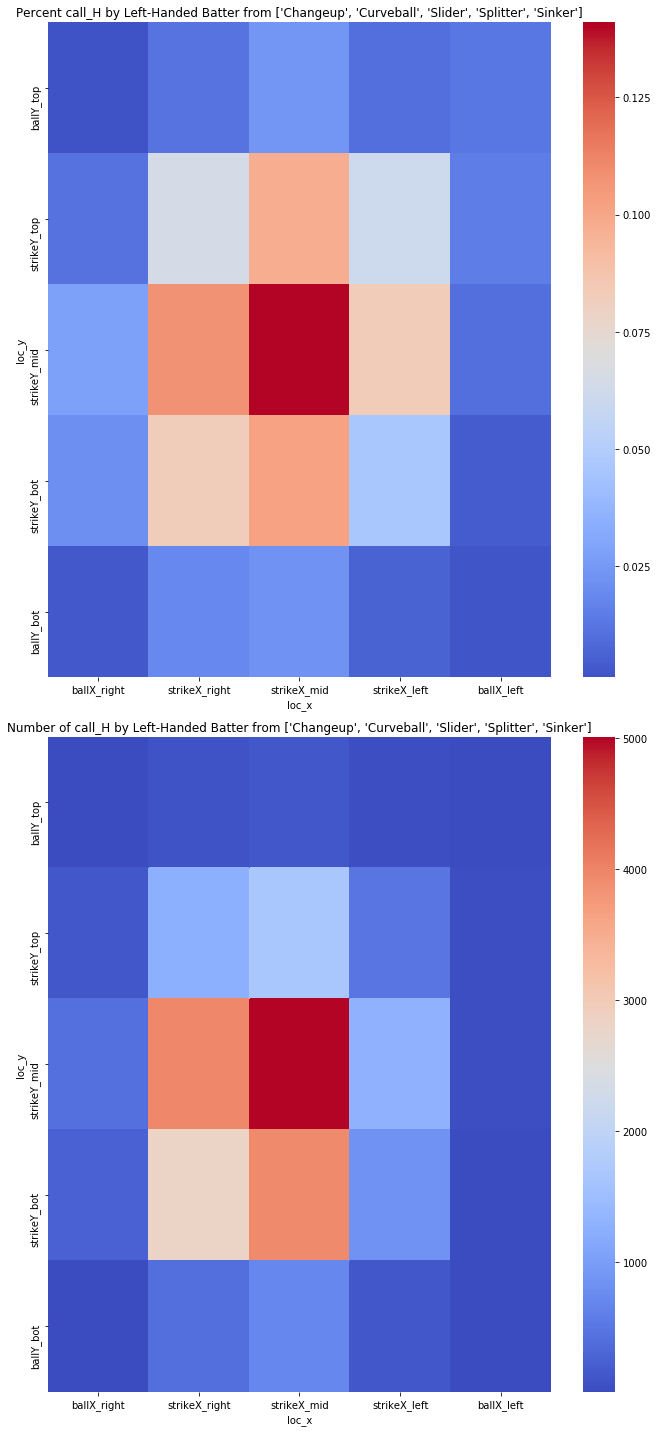

In [76]:
mistakes_left_hit_mean, mistakes_left_hit_count = heat_map(eda_df,
                                                           bat_side = 'Left',
                                                           pitch_types = mistake_pitches,
                                                           call = 'call_H')

In [82]:
loc_up = ['strikeY_top']
strikeX_zone = ['strikeX_right', 'strikeX_mid', 'strikeX_left']

In [78]:
t_testing(eda_df, 
         bat_side = 'Right',
         pitch_types = mistake_pitches,
         call = 'call_H',
         locx_zone = strikeX_zone,
         locy_zone = loc_up)

Total pitches: 326217. Mean call_H: 0.099881.
Total ['Changeup', 'Curveball', 'Slider', 'Splitter', 'Sinker']: 194131. Mean call_H: 0.107015.
There's a statistical significance for getting call_H against Right-handed batters by throwing a ['Changeup', 'Curveball', 'Slider', 'Splitter', 'Sinker'] at ['strikeX_right', 'strikeX_mid', 'strikeX_left'] and ['strikeY_top', 'strikeY_mid'] opposed to other pitches
Test statistic: -8.141250. P-value: 0.000000


In [79]:
t_testing(eda_df, 
         bat_side = 'Left',
         pitch_types = mistake_pitches,
         call = 'call_H',
         locx_zone = strikeX_zone,
         locy_zone = loc_up)

Total pitches: 237468. Mean call_H: 0.096194.
Total ['Changeup', 'Curveball', 'Slider', 'Splitter', 'Sinker']: 132641. Mean call_H: 0.103309.
There's a statistical significance for getting call_H against Left-handed batters by throwing a ['Changeup', 'Curveball', 'Slider', 'Splitter', 'Sinker'] at ['strikeX_right', 'strikeX_mid', 'strikeX_left'] and ['strikeY_top', 'strikeY_mid'] opposed to other pitches
Test statistic: -6.895932. P-value: 0.000000


As shown by ``t_testing`` for both left and right-handed batters, there is a statistically significant difference between the mean of hits for "mistake" pitches up in the strikezone and other types of pitches but the difference is so slight that practically, it may not have an influence. Again, this analysis doesn't account for situation, count, or pitch sequence so the analysis could be skewed a certain way.